# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

2024-12-16 18:28:43.730599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734391723.742162   22973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734391723.745722   22973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 18:28:43.758003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Dataset

In [2]:
train_dataset_path = 'Covid19-dataset/train/'
test_dataset_path = 'Covid19-dataset/test/'

In [3]:
data_generator = ImageDataGenerator(
    rescale=1/255
)

train_data = data_generator.flow_from_directory(
    train_dataset_path,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

test_data = data_generator.flow_from_directory(
    test_dataset_path,
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights based on the training data class distribution
class_labels = list(train_data.class_indices.keys())
classes = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.7537537537537538), 1: np.float64(1.1952380952380952), 2: np.float64(1.1952380952380952)}


# CNN Classifier Setup

In [6]:
# Build a Sequential CNN model
cnn_model = Sequential()

# Add convolutional and pooling layers
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))

# Add flatten and dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(128, activation='relu'))

# Output layer
cnn_model.add(Dense(3, activation='softmax'))

/home/mavwdj/.pyenv/versions/ml-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-16 18:28:46.082778: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,887,491 (64.42 MB)

 Trainable params: 16,887,491 (64.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the CNN model
cnn_history = cnn_model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    validation_steps=len(test_data)
)

/home/mavwdj/.pyenv/versions/ml-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 593ms/step - accuracy: 0.3830 - loss: 1.8991 - val_accuracy: 0.6364 - val_loss: 0.8724
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 581ms/step - accuracy: 0.7733 - loss: 0.5988 - val_accuracy: 0.8030 - val_loss: 0.4793
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 573ms/step - accuracy: 0.8546 - loss: 0.3666 - val_accuracy: 0.8485 - val_loss: 0.4094
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 582ms/step - accuracy: 0.9365 - loss: 0.1819 - val_accuracy: 0.8939 - val_loss: 0.2353
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 578ms/step - accuracy: 0.9622 - loss: 0.1375 - val_accuracy: 0.9242 - val_loss: 0.1743
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 581ms/step - accuracy: 0.9765 - loss: 0.0707 - val_accuracy: 0.8030 - val_loss: 0.4652
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 573ms/step - accuracy: 0.9816 - loss: 0.0663 - val_accuracy: 0.8939 - val_loss: 0.3496
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 573ms/step - accuracy: 0.9761 - loss: 0.0462 - val_accuracy: 0

# Visualize Training Results

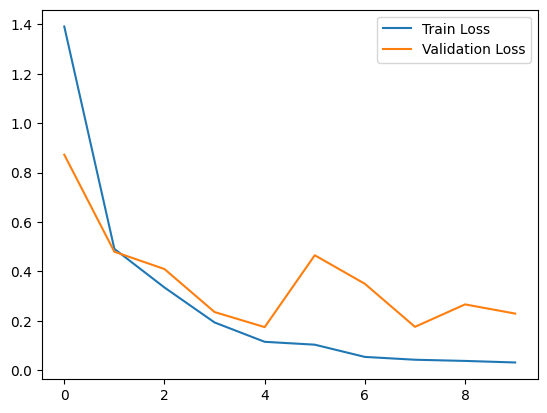

In [10]:
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

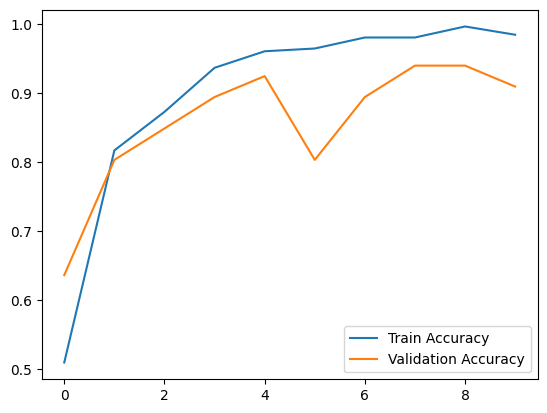

In [11]:
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [12]:
cnn_model.evaluate(test_data)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9266 - loss: 0.1469


[0.22904618084430695, 0.9090909361839294]

# Evaluate Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_data.reset()
predictions = cnn_model.predict(test_data, steps=len(test_data), verbose=1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Report:
                 precision    recall  f1-score   support

          Covid       1.00      0.92      0.96        26
         Normal       0.90      0.90      0.90        20
Viral Pneumonia       0.82      0.90      0.86        20

       accuracy                           0.91        66
      macro avg       0.91      0.91      0.91        66
   weighted avg       0.91      0.91      0.91        66

Confusion Matrix:
[[24  0  2]
 [ 0 18  2]
 [ 0  2 18]]
